In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import os
import json
from PIL import Image

import torch
import torchvision
import torchvision.transforms as transforms
import torch.optim as optim
import torchsummary
from torch.utils.data import Dataset, DataLoader, TensorDataset, random_split

#from tqdm import tqdm
from tqdm.notebook import tqdm

from torchviz import make_dot

from torchmetrics.classification import BinaryRecall, BinaryPrecision, BinaryF1Score

In [2]:
if torch.cuda.is_available():
    device = torch.device("cuda")
    print("CUDA is available. Using GPU.")
else:
    device = torch.device("cpu")
    print("CUDA is not available. Using CPU.")

CUDA is available. Using GPU.


In [3]:
base_path = "C:\\Users\\johnn\\Desktop\\Repos\\Capstonfire"
dataset_path = base_path + "\\full dataset"
#dataset_path = base_path + "\\FIRE + Forest Fire datasets"
test_path = base_path + "\\test dataset"
pretrained_models_path = base_path + "\\trained_models\\"

In [4]:
fire_files = os.listdir(dataset_path + "\\fire_images")
non_fire_files = os.listdir(dataset_path + "\\non_fire_images")

In [5]:
class FireDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.classes = sorted(os.listdir(root_dir))
        # Store the folder names in a dictionary as the class names alongside the class numeric label
        self.class_to_idx = {} 
        for i, cls in enumerate(self.classes):
            self.class_to_idx[cls] = i

        self.data = self._load_data()

    def _load_data(self):
        data = []
        for class_name in self.classes: # Fetch the folders through the class name
            class_path = os.path.join(self.root_dir, class_name)
            for filename in os.listdir(class_path): # Fetch the images inside each folders
                img_path = os.path.join(class_path, filename) # Obtain the name of the current image
                data.append((img_path, self.class_to_idx[class_name])) # Add the image to a list paired with its class' numeric label
        return data

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        img_path, label = self.data[idx]
        img = Image.open(img_path).convert("RGB")

        if self.transform:
            img = self.transform(img)

        return img, label

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Label: 0
Image shape: torch.Size([3, 256, 256])


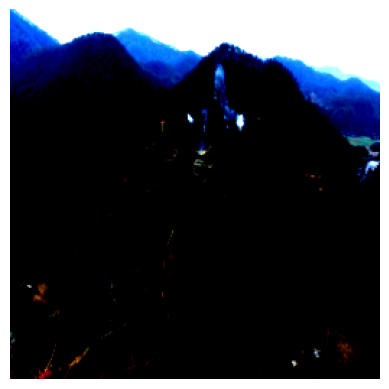

In [6]:
transform = transforms.Compose([
    transforms.Resize((256, 256)), # create a new model that resizes images based on aspect ratio
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    transforms.Lambda(lambda x: x.to(device))
])

dataset = FireDataset(dataset_path, transform=transform)

# Access an image and its label
img, label = dataset[0]
print("Label:", label)
# The image is a PyTorch tensor
print("Image shape:", img.shape)

# Convert the PyTorch tensor to a NumPy array and permute dimensions if necessary
img_np = img.detach().cpu().numpy() if img.is_cuda else img.numpy()

img_np = np.transpose(img_np, (1, 2, 0))

# Display the image using Matplotlib
plt.imshow(img_np)
plt.axis('off')
plt.show()

In [7]:
batch_size = 50

In [8]:
train_size = 0.7
val_size = 0.2
test_size = 0.1

train_dataset, val_dataset, test_dataset = random_split(dataset=dataset, lengths=[train_size, val_size, test_size])

train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(dataset=val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)

In [9]:
len(train_loader.dataset)

4847

In [10]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3) # to capture basic patterns from the image
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3) # to capture basic patterns from the previous patterns (results in capturing more complex patterns from the original image)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3)
        self.fc1 = nn.Linear(128*30*30, 64) # number of channels of the last Conv2D (10) * width obtained from the kernel's width (30) * height (30)
        self.fc2 = nn.Linear(64, 32) # DNN > WNN; also 1 classes
        self.fc3 = nn.Linear(32, 1)
        # self.fc2 = nn.Linear (256, 64)
        # self.fc3 = nn.Linear (64, 1)

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2(x), 2))
        x = F.relu(F.max_pool2d(self.conv3(x), 2))
        x = x.view(-1, 128*30*30)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = torch.sigmoid(self.fc3(x)) #used in binary classification
        #x = self.fc2(x)
        #return F.log_softmax(x, dim=1) #used in multi-class classification 
        return x

model = SimpleCNN().to(device)

In [11]:
torchsummary.summary(model=model, input_size=(3, 256, 256))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 254, 254]             896
            Conv2d-2         [-1, 64, 125, 125]          18,496
            Conv2d-3          [-1, 128, 60, 60]          73,856
            Linear-4                   [-1, 64]       7,372,864
            Linear-5                   [-1, 32]           2,080
            Linear-6                    [-1, 1]              33
Total params: 7,468,225
Trainable params: 7,468,225
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.75
Forward/backward pass size (MB): 26.90
Params size (MB): 28.49
Estimated Total Size (MB): 56.14
----------------------------------------------------------------


In [ ]:
x = torch.randn(50, 3, 256, 256).to(device)  # A dummy input tensor to pass through the model
y = model(x)

dot = make_dot(y, params=dict(list(model.named_parameters()) + [('x', x)]))
dot.render('model details/model_visualization', format='png')

In [13]:
# Step 2: Define Loss Function and Optimizer
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0003)

In [14]:
model_name = "capstonfire_deeper_cnn"
#model_name = "capstonfire_cnn"

hist_file_path = "trained_models/" + model_name + '.json'

In [15]:
history = {
    "avg_train_loss_list": [],
    "train_accuracy_list": [],
    "avg_val_loss_list": [],
    "val_accuracy_list": []
}

In [28]:
 # Step 3: Training Loop
 # avoid loop if the model was already trained

skip_saving : bool = False
if model_name + '.pt' in os.listdir(pretrained_models_path):
    skip_saving = True
    model.load_state_dict(torch.load(pretrained_models_path + model_name +'.pt'))
    
    with open(hist_file_path, 'r') as json_file:
        history = json.load(json_file)

# if model was never trained, enter loop
else:
    num_epochs = 100
    for epoch in tqdm(list(range(num_epochs))):
        model.train()

        running_loss = 0.0
        correct_train = 0
        total_train = 0

        for i, data in enumerate(train_loader, 0):
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)

            # For binary classification, modify target labels shape
            labels = labels.view(-1, 1).float()

            optimizer.zero_grad()  # zero the parameter gradients
            outputs = model(inputs)  # forward
            loss = criterion(outputs, labels)  # calculate loss
            loss.backward()  # backward
            optimizer.step()  # optimize

            predicted_binary = (torch.sigmoid(outputs) > 0.5).float()
            correct_train += (predicted_binary == labels).sum().item()
            
            total_train += labels.size(0)

            running_loss += loss.item()

        avg_train_loss = running_loss / len(train_loader)
        train_accuracy = correct_train / total_train
            
        model.eval()  # Set the model to evaluation mode
        with torch.no_grad():
            correct_val = 0
            total_val = 0
            val_loss = 0.0

            for inputs_val, labels_val in val_loader:
                inputs_val, labels_val = inputs_val.to(device), labels_val.to(device)

                labels_val = labels_val.view(-1, 1).float()

                outputs_val = model(inputs_val)
                loss_val = criterion(outputs_val, labels_val)

                predicted_binary = (torch.sigmoid(outputs_val) > 0.5).float()
                correct_val += (predicted_binary == labels_val).sum().item()

                total_val += labels_val.size(0)

                val_loss += loss_val.item()

        avg_val_loss = val_loss / len(val_loader)
        val_accuracy = correct_val / total_val

        history["avg_train_loss_list"].append(avg_train_loss)
        history["train_accuracy_list"].append(train_accuracy)
        history["avg_val_loss_list"].append(avg_val_loss)
        history["val_accuracy_list"].append(val_accuracy)

        print(f'Epoch [{epoch+1}/{num_epochs}], '
            f'Train Loss: {avg_train_loss:.4f}, Train Accuracy: {train_accuracy:.4f}, '
            f'Validation Loss: {avg_val_loss:.4f}, Validation Accuracy: {val_accuracy:.4f}')

    print('Finished Training')

  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [1/25], Train Loss: 0.5142, Train Accuracy: 0.9140, Validation Loss: 0.5313, Validation Accuracy: 0.9141
Epoch [2/25], Train Loss: 0.5140, Train Accuracy: 0.9266, Validation Loss: 0.5317, Validation Accuracy: 0.9083
Epoch [3/25], Train Loss: 0.5154, Train Accuracy: 0.9272, Validation Loss: 0.5433, Validation Accuracy: 0.8751
Epoch [4/25], Train Loss: 0.5213, Train Accuracy: 0.9239, Validation Loss: 0.5357, Validation Accuracy: 0.8628
Epoch [5/25], Train Loss: 0.5150, Train Accuracy: 0.9121, Validation Loss: 0.5336, Validation Accuracy: 0.9112
Epoch [6/25], Train Loss: 0.5160, Train Accuracy: 0.9212, Validation Loss: 0.5351, Validation Accuracy: 0.8758
Epoch [7/25], Train Loss: 0.5142, Train Accuracy: 0.9294, Validation Loss: 0.5340, Validation Accuracy: 0.8816
Epoch [8/25], Train Loss: 0.5145, Train Accuracy: 0.9294, Validation Loss: 0.5351, Validation Accuracy: 0.9134
Epoch [9/25], Train Loss: 0.5150, Train Accuracy: 0.9245, Validation Loss: 0.5335, Validation Accuracy: 0.9170
E

In [29]:
if not skip_saving:
    # save pytorch model
    torch.save(model.state_dict(), "trained_models/" + model_name + '.pt')

    # Write history dictionary to a JSON file
    with open(hist_file_path, 'w+') as json_file:
        json.dump(history, json_file)

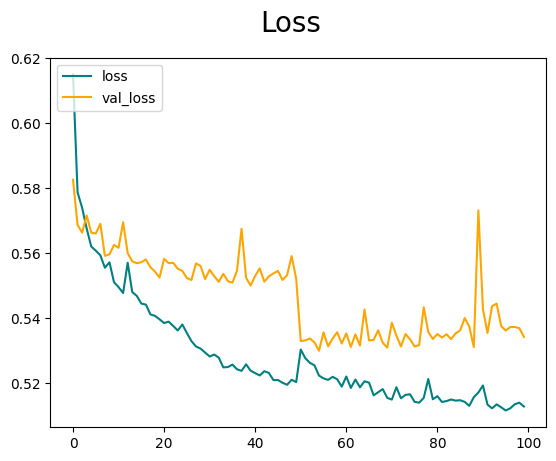

In [30]:
fig = plt.figure()
plt.plot(history["avg_train_loss_list"], color='teal', label='loss')
plt.plot(history["avg_val_loss_list"], color='orange', label='val_loss')
fig.suptitle('Loss', fontsize=20)
plt.legend(loc="upper left")
plt.show()

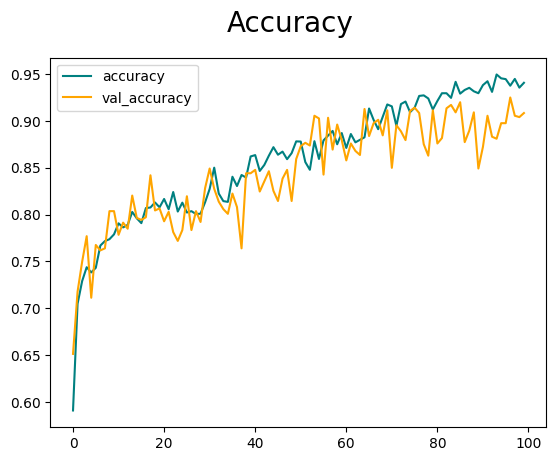

In [31]:
fig = plt.figure()
plt.plot(history["train_accuracy_list"], color='teal', label='accuracy')
plt.plot(history["val_accuracy_list"], color='orange', label='val_accuracy')
fig.suptitle('Accuracy', fontsize=20)
plt.legend(loc="upper left")
plt.show()

In [32]:
recall = BinaryRecall(threshold=0.5).to(device)
precision = BinaryPrecision(threshold=0.5).to(device)
f1 = BinaryF1Score(threshold=0.5).to(device)

with torch.no_grad():
    for data in tqdm(test_loader):
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)
        labels = labels.view(-1, 1).float()
        outputs = model(inputs)  # forward
        predicted_binary = (torch.sigmoid(outputs) > 0.5).float()
        #predictions = torch.argmax(outputs, dim=1)

        recall.update(predicted_binary, labels)
        precision.update(predicted_binary, labels)
        f1.update(predicted_binary, labels)

print('Recall on the test set: %.2f' % (recall.compute()))
print('Precision on the test set: %.2f' % (precision.compute()))
print('F1 Score on the test set: %.2f' % (f1.compute()))

  0%|          | 0/14 [00:00<?, ?it/s]

Recall on the test set: 0.94
Precision on the test set: 0.90
F1 Score on the test set: 0.92


In [33]:
custom_test_loader = DataLoader(FireDataset(test_path, transform=transform), batch_size=batch_size, shuffle=False)

with torch.no_grad():
    for data in tqdm(custom_test_loader):
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)
        labels = labels.view(-1, 1).float()
        outputs = model(inputs)  # forward
        predicted_binary = (torch.sigmoid(outputs) > 0.5).float()
        #predictions = torch.argmax(outputs, dim=1)

        recall.update(predicted_binary, labels)
        precision.update(predicted_binary, labels)
        f1.update(predicted_binary, labels)

print('Recall on the test set: %.2f' % (recall.compute()))
print('Precision on the test set: %.2f' % (precision.compute()))
print('F1 Score on the test set: %.2f' % (f1.compute()))

  0%|          | 0/19 [00:00<?, ?it/s]

Recall on the test set: 0.40
Precision on the test set: 0.87
F1 Score on the test set: 0.55


In [ ]:
#cross-validation
#perturbações

Looks like this model did not work out that well.